In [1]:
addprocs(5);

In [1]:
using Revise
using Grid
using Plots
using JuMIT
#using PyPlot

INFO: Recompiling stale cache file /math/home/pawbz/.julia/lib/v0.6/JuMIT.ji for module JuMIT.


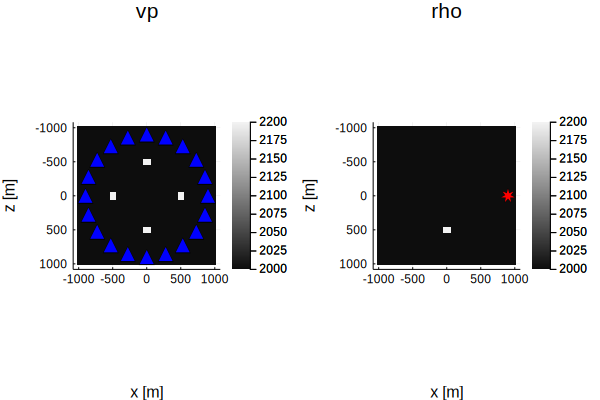

In [2]:
model = JuMIT.Gallery.Seismic(:acou_homo2);
#model = JuMIT.Gallery.Seismic(:seismic_marmousi2_downhole);
#model = JuMIT.Models.Seismic_addon(model, ellip_rad=10., ellip_loc=[-000.,0.],ellip_pert=0.2)
JuMIT.Models.Seismic_addon!(model, ellip_rad=50., ellip_loc=[500.,0.],ellip_pert=0.1,randn_perc=0.0, fields=[:χvp,:χρ])
JuMIT.Models.Seismic_addon!(model, ellip_rad=50., ellip_loc=[0.,500.],ellip_pert=0.1,randn_perc=0.0, fields=[:χvp])
JuMIT.Models.Seismic_addon!(model, ellip_rad=50., ellip_loc=[-500.,0.],ellip_pert=0.1,randn_perc=0.0, fields=[:χvp])
JuMIT.Models.Seismic_addon!(model, ellip_rad=50., ellip_loc=[0.,-500.],ellip_pert=0.1,randn_perc=0.0, fields=[:χvp])
#model = JuMIT.Models.Seismic_addon(model, ellip_pert=0.2, rect_loc=[-200.,-500.,200.,500.] )
model0 = JuMIT.Gallery.Seismic(:acou_homo2);
acqgeom = JuMIT.Acquisition.Geom_circ(nss=1,nr=20,rad=[900.,900.])#,θlim=[90.,180.]);

#tgrid = JuMIT.Grid.M1D_resamp(tgrid, tgrid.δx/2.0)
JuMIT.Plots.seismic(model, color=:autumn )
JuMIT.Plots.geom!(acqgeom, markersize=7, subplot=[1,2])

	Source Acquisition:	
	> number of supersources:	1
	> sources per supersource:	min	1	max	1
	> frequency:	min	0.3538461538461538	max	8.846153846153845	peak	2.8307692307692305
	> time:	min	0.0	max	2.8173913043478263
	> samples:	325


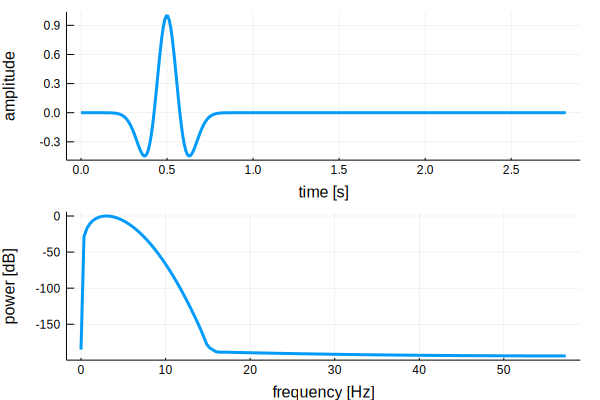

In [3]:
acqsrc=JuMIT.Acquisition.Src_fixed_mod(acqgeom.nss,1,[:P],mod=model,nλ=3)
tgrid=acqsrc.tgrid
JuMIT.Plots.src(acqsrc, w=3)

In [333]:
@time pa = JuMIT.FWI.Param(acqsrc,mprecon_factor=1.0, 
    acqgeom, tgrid,:fdtd,:migr,model0,modm_obs=model, 
    igrid=Grid.M2D_resamp(model.mgrid,50.,50.,), 
    tlagssf_fracs=[0.1,0.4],
    optims=[:cls],
    verbose=false);

  0.347603 seconds (156.95 k allocations: 18.278 MiB)


updating modm and modi...
> xfwi: number of inversion variables:	3362
maximum value of g(x):	0.000385696221101087
  0.456884 seconds (378.06 k allocations: 11.238 MiB)


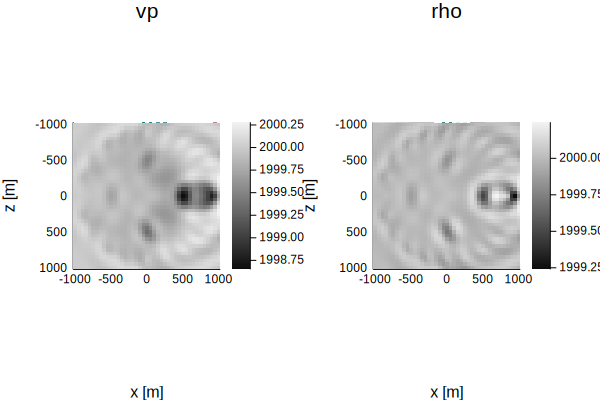

In [334]:
@time migr2 = JuMIT.FWI.xfwi!(pa)
JuMIT.Plots.seismic(migr2)

In [303]:
x=zeros(JuMIT.FWI.xfwi_ninv(pa))
storage=similar(x)
last_x=randn(JuMIT.FWI.xfwi_ninv(pa))
@time JuMIT.FWI.func_grad_xfwi!(nothing,x, last_x, pa)
last_x=randn(JuMIT.FWI.xfwi_ninv(pa))
@time JuMIT.FWI.F!(pa, x, last_x)


  0.538727 seconds (166.55 k allocations: 5.229 MiB)
  0.289990 seconds (96.69 k allocations: 2.648 MiB)


JuMIT.Data.TD(Array{Float64,2}[[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]], Symbol[:P], Grid.M1D([0.0, 0.00869565, 0.0173913, 0.026087, 0.0347826, 0.0434783, 0.0521739, 0.0608696, 0.0695652, 0.0782609  …  2.73913, 2.74783, 2.75652, 2.76522, 2.77391, 2.78261, 2.7913, 2.8, 2.8087, 2.81739], 325, 0.008695652173913044), JuMIT.Acquisition.Geom(Array{Float64,1}[[900.0]], Array{Float64,1}[[0.0]], Array{Float64,1}[[900.0, 855.951, 728.115, 529.007, 278.115, 5.51091e-14, -278.115, -529.007, -728.115, -855.951, -900.0, -855.951, -728.115, -529.007, -278.115, -1.65327e-13, 278.115, 529.007, 728.115, 855.951]], Array{Float64,1}[[0.0, 278.115, 529.007, 728.115, 855.951, 900.0, 855.951, 728.115, 529.007, 278.115, 1.10218e-13, -278.115, -529.007, -728.115, -855.951, -900.0, -855.951, -728.115, -529.007, -278.115]], 1, [1], [20]))

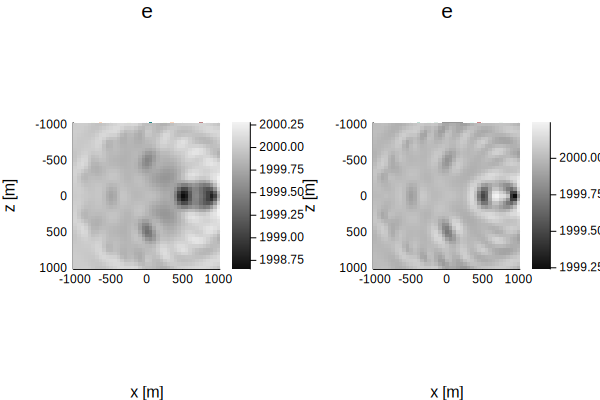

In [296]:
JuMIT.Plots.seismic(migr2, title="e","f")

In [337]:
@time pa = JuMIT.FWI.Param(acqsrc,mprecon_factor=1.0, 
    acqgeom, tgrid,:fdtd,:migr,model0,modm_obs=model, 
    igrid=Grid.M2D_resamp(model.mgrid,50.,50.,), 
    tlagssf_fracs=[0.1,0.4],
    optims=[:cls],
    verbose=false, born_flag=true);

  0.622377 seconds (562.69 k allocations: 25.340 MiB)


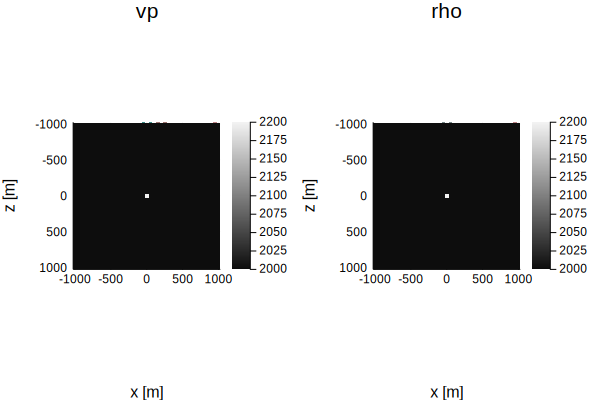

In [343]:
a=JuMIT.FWI.Fadj_Fborn_x!([0.,0.,], pa)
JuMIT.Plots.seismic(a[3])
#JuMIT.Plots.td(pa.paTD.x)

In [378]:
x=JuMIT.FWI.xfwi_pert_x(pa, [0,0]);

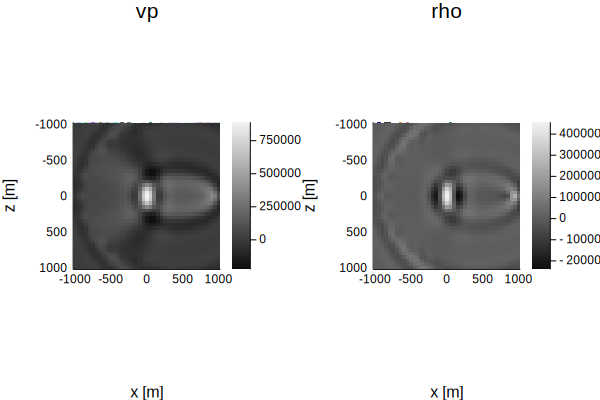

In [379]:
xx=zeros(x)
JuMIT.FWI.Fadj_Fborn_x!(xx,x,pa)
JuMIT.Plots.seismic(a[1])

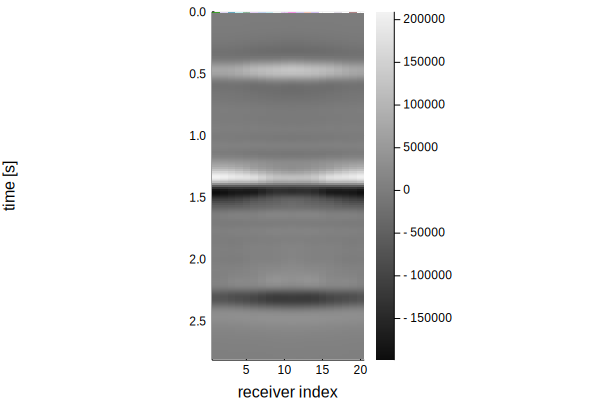

In [227]:
JuMIT.Plots.td(pa.paTD.x

In [228]:
@time pac = JuMIT.FWI.Param(acqsrc,mprecon_factor=1.0, #tlagssf_fracs=[0.1,0.1],
    acqgeom, tgrid,:fdtd,:cls,model0,modm_obs=model, igrid=Grid.M2D_resamp(model.mgrid,50.,50.,));

FCDACCa0.0


FCDACCa0.0
FCDACCa0.0
FCDACCa0.0
  0.434519 seconds (184.35 k allocations: 21.783 MiB)


In [102]:
JuMIT.FWI.xfwi!(pac, bounded_flag=true)

updating modm and modi...
> xfwi: number of inversion variables:	3362
FCDACCa0.0
FCDACCa0.0751606847556464
FCDACCa0.0751606847556464
FCDACCa0.0751606847556464
FCDACCa0.0
FCDACCa0.07510515644798035
FCDACCa0.0
FCDACCa0.07488391917615944
FCDACCa0.0
FCDACCa0.07379851336266728
FCDACCa0.0
FCDACCa0.07409821649054152
FCDACCa0.0
FCDACCa0.07410009208486457
FCDACCa0.0
FCDACCa0.07410796508205812
FCDACCa0.0
FCDACCa0.0741562710617158
FCDACCa0.0
FCDACCa0.07415350052472114
FCDACCa0.0
FCDACCa0.07413351408152695
FCDACCa0.0
FCDACCa0.07405395926568759
FCDACCa0.0
FCDACCa0.07366551402686015
FCDACCa0.0
FCDACCa0.07384766340724024
FCDACCa0.0
FCDACCa0.0738855681114188
FCDACCa0.0
FCDACCa0.07405674107651679
FCDACCa0.0
FCDACCa0.07539718087175866
FCDACCa0.0
FCDACCa0.0741162319397092
FCDACCa0.0
FCDACCa0.07408041611835468
FCDACCa0.0
FCDACCa0.07393829689597407
FCDACCa0.0
FCDACCa0.07402567071433697
FCDACCa0.0
FCDACCa0.07402092350663839
FCDACCa0.0
FCDACCa0.07400221159967034
FCDACCa0.0
FCDACCa0.07391524157043719
FCDACCa0

LoadError: [91m[91m[91mInterruptException:[39m
boundary_save_snap_p!(::Int64, ::JuMIT.Fdtd.Paramc, ::Array{JuMIT.Fdtd.Paramss,1}, ::JuMIT.Fdtd.Paramp) at /math/home/pawbz/.julia/v0.6/JuMIT/src/Fdtd.jl:1337
mod_per_proc!(::JuMIT.Fdtd.Paramc, ::JuMIT.Fdtd.Paramp) at /math/home/pawbz/.julia/v0.6/JuMIT/src/Fdtd.jl:930
run_work_thunk(::JuMIT.Fdtd.##65#71{JuMIT.Fdtd.Param}, ::Bool) at ./distributed/process_messages.jl:56
run_work_thunk(::Base.Distributed.RemoteValue, ::Function) at ./distributed/process_messages.jl:65
(::Base.Distributed.##96#98{Base.Distributed.RemoteValue,JuMIT.Fdtd.##65#71{JuMIT.Fdtd.Param}})() at ./event.jl:73[39m
wait_ref(::Base.Distributed.RRID, ::Int64) at ./distributed/remotecall.jl:453
call_on_owner(::Function, ::Future, ::Int64, ::Vararg{Int64,N} where N) at ./distributed/remotecall.jl:443
wait at ./distributed/remotecall.jl:460 [inlined]
#remotecall_wait#145(::Array{Any,1}, ::Function, ::Function, ::Base.Distributed.LocalProcess) at ./distributed/remotecall.jl:375
remotecall_wait(::Function, ::Base.Distributed.LocalProcess) at ./distributed/remotecall.jl:375
#remotecall_wait#149(::Array{Any,1}, ::Function, ::Function, ::Int64) at ./distributed/remotecall.jl:399
remotecall_wait(::Function, ::Int64) at ./distributed/remotecall.jl:399
(::JuMIT.Fdtd.##64#70{JuMIT.Fdtd.Param})() at ./task.jl:335[39m

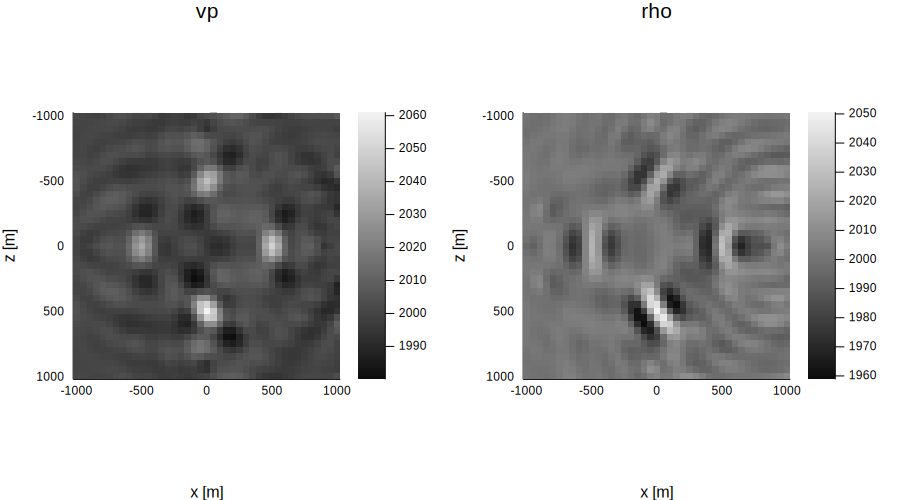

In [11]:
JuMIT.Plots.seismic(pac.modi, size=(900,500))

In [137]:
pac.modm.χvp===model0.χvp

false

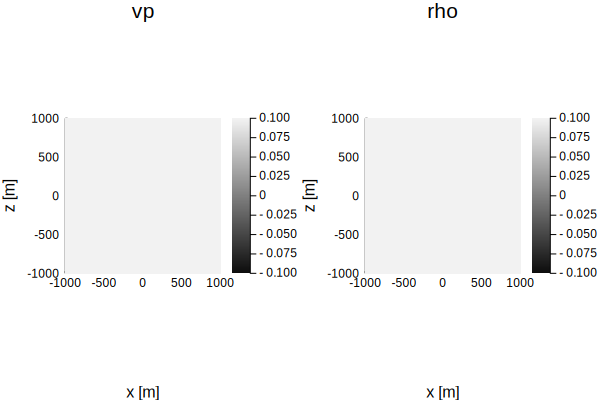

In [138]:
JuMIT.Plots.seismic(model0)

In [352]:
using BenchmarkTools

In [370]:
function f1(x)
    f=0.0
    for i in eachindex(x)
        f+=abs2(x[i])
    end
    return f
end
function f2(x)
    f=0.0
    for i in eachindex(x)
        f+=abs(x[i])
    end
    return f
end

f2 (generic function with 1 method)

In [371]:
function fv(x, fvec)
    f1=f1(x)
    f2=f2(x)
    f=f1+f2
   # for ifunc in fvec
    #    f+=ifunc(x)
    #end
    return f
end

fv (generic function with 1 method)

In [372]:
x=randn(100);
@time f1(x)
@time f2(x)
@time fv(x, [f1,f2])


  0.026482 seconds (1.23 k allocations: 65.387 KiB)
  0.018034 seconds (1.22 k allocations: 64.762 KiB)


LoadError: [91mUndefVarError: f1 not defined[39m